In [ ]:
pip install pandas transformers torch tensorflow seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 124.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.4 MB/s eta 0:00:00


Epoch 1/10
100/100 [==============================] - 2s 14ms/step - loss: 0.1237 - accuracy: 0.9606 - val_loss: 0.0181 - val_accuracy: 0.9987
Epoch 2/10
100/100 [==============================] - 1s 13ms/step - loss: 0.0166 - accuracy: 0.9966 - val_loss: 0.0098 - val_accuracy: 0.9975
Epoch 3/10
100/100 [==============================] - 1s 13ms/step - loss: 0.0094 - accuracy: 0.9975 - val_loss: 0.0095 - val_accuracy: 0.9962
Epoch 4/10
100/100 [==============================] - 1s 13ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0034 - val_accuracy: 0.9987
Epoch 5/10
100/100 [==============================] - 2s 17ms/step - loss: 6.9885e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9987
Epoch 6/10
100/100 [==============================] - 2s 19ms/step - loss: 3.3872e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9987
Epoch 7/10
100/100 [==============================] - 1s 13ms/step - loss: 2.1700e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accu

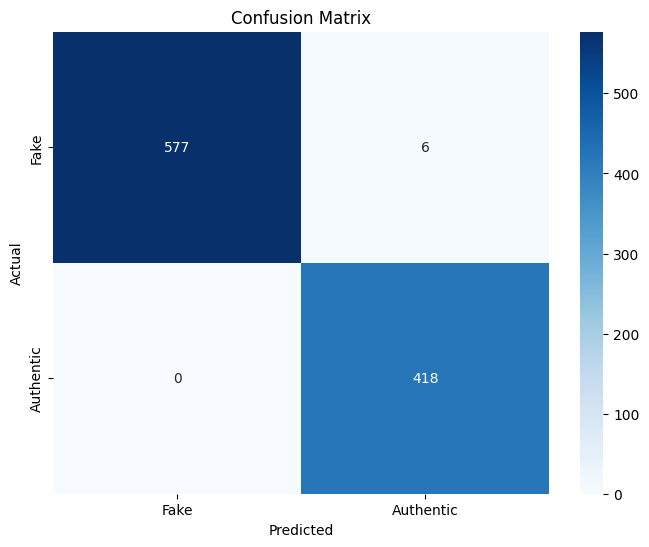

In [ ]:
import json
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and preprocess the data
with open('authentic_nft_data.json', 'r') as file:
    authentic_nft_data = json.load(file)
with open('fake_nft.json', 'r') as file:
    fake_nft_data = json.load(file)

# Convert to DataFrame
authentic_nft_df = pd.DataFrame(authentic_nft_data)
fake_nft_df = pd.DataFrame(fake_nft_data)

# Expand nested columns and label the data
authentic_nft_expanded = pd.json_normalize(authentic_nft_df['result'])
fake_nft_expanded = pd.json_normalize(fake_nft_df['result'])
authentic_nft_expanded['label'] = 1
fake_nft_expanded['label'] = 0

# Combine and fill missing values
combined_nft_data = pd.concat([authentic_nft_expanded, fake_nft_expanded], ignore_index=True)
combined_nft_data.fillna({
    'name': 'Unknown',
    'description': 'Unknown',
    'royalty': 0,
    'symbol': 'Unknown',
    'primary_sale_happened': False,
    'collection.verified': False,
    'owner': 'Unknown'
}, inplace=True)

# 2. Extract features using BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def encode_with_bert(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Extract features
encoded_names = np.stack(combined_nft_data['name'].apply(encode_with_bert))
encoded_descriptions = np.stack(combined_nft_data['description'].apply(encode_with_bert))

# Combine features
X = np.hstack([encoded_names, encoded_descriptions])
y = combined_nft_data['label'].values

# 3. Split the data and define CNN model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data
X_train_reshaped = X_train.reshape(-1, 128, 12)
X_test_reshaped = X_test.reshape(-1, 128, 12)

# Define CNN model
input_shape = (128, 12)
text_input = Input(shape=input_shape, name='text_input')
conv1 = Conv1D(128, 5, activation='relu')(text_input)
pool1 = MaxPooling1D(5)(conv1)
conv2 = Conv1D(128, 5, activation='relu')(pool1)
pool2 = MaxPooling1D(5)(conv2)
flatten = Flatten()(pool2)
dense1 = Dense(128, activation='relu')(flatten)
output = Dense(1, activation='sigmoid')(dense1)

# Compile the model
model = Model(inputs=[text_input], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train the model
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# 5. Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
y_pred = model.predict(X_test_reshaped)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

# Print results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Authentic'], yticklabels=['Fake', 'Authentic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

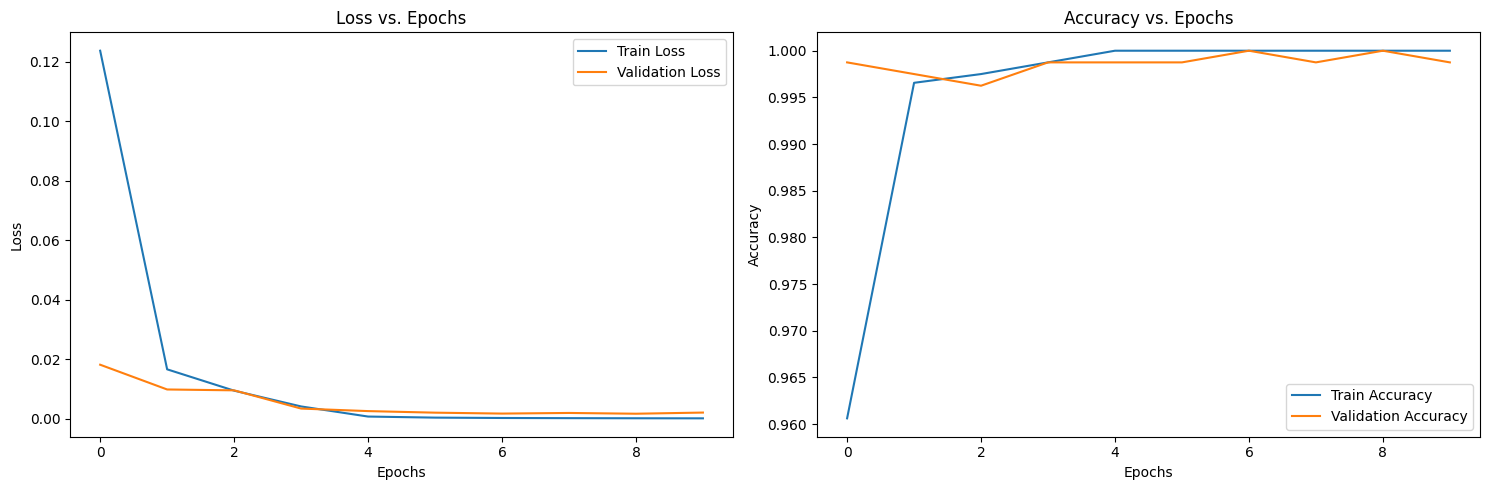

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting accuracy
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Extract indices of misclassified instances
misclassified_indices = np.where(y_pred_binary.squeeze() != y_test)[0]

# Display the number of misclassified instances
print(f"Number of misclassified instances: {len(misclassified_indices)}\n")

# Iterate over the misclassified instances and display details
for idx in misclassified_indices:
    print(f"Index: {idx}")
    print(f"Actual Label: {'Authentic' if y_test[idx] == 1 else 'Fake'}")
    print(f"Predicted Label: {'Authentic' if y_pred_binary[idx] == 1 else 'Fake'}")
    print(f"Description: {combined_nft_data.iloc[idx]['description']}")
    print(f"Model Confidence: {y_pred[idx][0]}")
    print("-----------------------------------------------------------\n")

Number of misclassified instances: 6

Index: 210
Actual Label: Fake
Predicted Label: Authentic
Description: 6666 Rascals causing Mayhem in the Solana Space.
Model Confidence: 0.9209694266319275
-----------------------------------------------------------

Index: 304
Actual Label: Fake
Predicted Label: Authentic
Description: Puffsterz Corp is a street brand retail chain that consists of 1888 NFTs PFP style collection. Seeking to build a stable ecosystem to give back to the holders via our Task To Earn protocol marketing platform. Growing our network both in Web2 & Web3
Model Confidence: 0.7072576880455017
-----------------------------------------------------------

Index: 348
Actual Label: Fake
Predicted Label: Authentic
Description: A Community Brand Capturing the Spirit of Perseverance and Ambition, in Style.
Model Confidence: 0.8398867845535278
-----------------------------------------------------------

Index: 550
Actual Label: Fake
Predicted Label: Authentic
Description: Taiyo infan

In [ ]:
# Extract indices of correctly classified Authentic instances
correct_authentic_indices = np.where((y_pred_binary.squeeze() == y_test) & (y_test == 1))[0]

# Display the number of correctly classified Authentic instances
print(f"Number of correctly classified Authentic instances: {len(correct_authentic_indices)}\n")

# For demonstration purposes, let's display details for the first 10 correctly classified Authentic instances
for idx in correct_authentic_indices[:100]:
    print(f"Index: {idx}")
    print(f"Actual Label: {'Authentic' if y_test[idx] == 1 else 'Fake'}")
    print(f"Predicted Label: {'Authentic' if y_pred_binary[idx] == 1 else 'Fake'}")
    print(f"Description: {combined_nft_data.iloc[idx]['description']}")
    print(f"Model Confidence: {y_pred[idx][0]}")
    print("-----------------------------------------------------------\n")

Number of correctly classified Authentic instances: 418

Index: 0
Actual Label: Authentic
Predicted Label: Authentic
Description: Citizens of Lunar city.
Model Confidence: 0.9999986886978149
-----------------------------------------------------------

Index: 3
Actual Label: Authentic
Predicted Label: Authentic
Description: Citizens of Lunar city.
Model Confidence: 0.9999998807907104
-----------------------------------------------------------

Index: 4
Actual Label: Authentic
Predicted Label: Authentic
Description: Citizens of Lunar city.
Model Confidence: 0.9999974370002747
-----------------------------------------------------------

Index: 5
Actual Label: Authentic
Predicted Label: Authentic
Description: Citizens of Lunar city.
Model Confidence: 0.9999871850013733
-----------------------------------------------------------

Index: 6
Actual Label: Authentic
Predicted Label: Authentic
Description: Citizens of Lunar city.
Model Confidence: 0.9999960660934448
-----------------------------

In [ ]:
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

# If you haven't downloaded the NLTK punkt tokenizer models, do so by uncommenting the line below
nltk.download('punkt')

# Tokenize descriptions
def get_tokens(descriptions):
    tokens = []
    for desc in descriptions:
        tokens.extend(word_tokenize(desc.lower()))
    return tokens

# Get tokens for misclassified descriptions
misclassified_descriptions = [
    "A Community Brand Capturing the Spirit of Perseverance and Ambition, in Style.",
    "Taiyo infant hatched after 30 days of Incubation",
    "Taiyo infant hatched after 30 days of Incubation",
    "BroHalla Awaits.."
]
misclassified_tokens = get_tokens(misclassified_descriptions)

# Get tokens for correctly classified Authentic descriptions
correct_authentic_descriptions = combined_nft_data.iloc[correct_authentic_indices]['description'].tolist()[:10]
correct_authentic_tokens = get_tokens(correct_authentic_descriptions)

# Count token frequencies
misclassified_counter = Counter(misclassified_tokens)
correct_authentic_counter = Counter(correct_authentic_tokens)

# Display most common tokens
print("Most Common Tokens in Misclassified Descriptions:")
print(misclassified_counter.most_common(100))
print("\n")
print("Most Common Tokens in Correctly Classified Authentic Descriptions:")
print(correct_authentic_counter.most_common(100))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Most Common Tokens in Misclassified Descriptions:
[('of', 3), ('taiyo', 2), ('infant', 2), ('hatched', 2), ('after', 2), ('30', 2), ('days', 2), ('incubation', 2), ('a', 1), ('community', 1), ('brand', 1), ('capturing', 1), ('the', 1), ('spirit', 1), ('perseverance', 1), ('and', 1), ('ambition', 1), (',', 1), ('in', 1), ('style', 1), ('.', 1), ('brohalla', 1), ('awaits', 1), ('..', 1)]


Most Common Tokens in Correctly Classified Authentic Descriptions:
[('citizens', 10), ('of', 10), ('lunar', 10), ('city', 10), ('.', 10)]


In [ ]:
model.save('my_model.h5')

In [ ]:
from google.colab import files

files.download('my_model.h5')